## Load python modules

In [2]:
# system python modules
import sys, os.path

# numpy modules
import numpy as np

# landlab modules
from landlab import RasterModelGrid, CLOSED_BOUNDARY, FIXED_VALUE_BOUNDARY
from landlab.io import read_esri_ascii
from landlab import imshow_grid
from landlab.components import SoilInfiltrationGreenAmpt
from landlab.components import OverlandFlow

# Plotting modules
from matplotlib import pyplot as plt
import matplotlib as mpl

# path with topography dem data
topopath=os.path.join("..","topographies")

%matplotlib inline

## Setup data for the run

### Define the storm conditions (mm/hr)

In [3]:
storm_flag = '2009-02-10'

if storm_flag == '1995-11-18':
    starting_precip_mmhr = 15.6
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 17100.
elif storm_flag == '1997-03-11':
    starting_precip_mmhr = 34.8
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 4500.
elif storm_flag == '2009-02-10':
    starting_precip_mmhr = 18.
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 7200.
elif storm_flag == '2010-12-08':
    starting_precip_mmhr = 16.8
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 5400.
elif storm_flag == '2012-11-24':
    starting_precip_mmhr = 16.8
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 3900.

### Setup the run time and logging

In [4]:
# Simulation run time and report time as function of storm duration
runHours = 2.5 * storm_duration/3600.  
model_run_time = runHours * 3600.
reportInterval = model_run_time / 3.

# graphs and data during run time?
showProgress = True
showPlots = False

### Load topography and create the raster model grid

In [5]:
(rmg, z) = read_esri_ascii(os.path.join(topopath,'clipped2cropped2.asc'), name='topographic__elevation')

### Initialise variables

In [6]:
# Depth of water above the surface [m]
h = rmg.add_ones('node', 'surface_water__depth')
h *= 0.023

# Water column height above the surface previously absorbed into the soil [m]
# This is NOT the actual depth of the wetted front, which also depends on the porosity
d = rmg.add_ones('node', 'soil_water_infiltration__depth', dtype=float)
d *= 0.15

# Terrain roughness
mannings_n = 0.05  

# Soil type and hydraulic conductivity [m/s]
# The ease with which a fluid (usually water) can move through pore spaces or fractures
# Specify range and initialise the field with random values in this range
soil_type = 'sandy loam'
min_h = 5e-6
max_h = 5.5e-6
hydraulic_conductivity = rmg.ones('node')*min_h
hydraulic_conductivity += np.random.rand(z.size)*(max_h - min_h)  

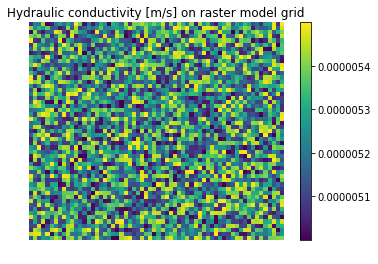

In [7]:
# Visualise the randomness of the hydraulic conductivity
plt.imshow(hydraulic_conductivity.reshape((rmg.shape[0],rmg.shape[1])))
plt.colorbar()
plt.title('Hydraulic conductivity [m/s] on raster model grid')
plt.axis('off')
plt.show()

### Set boundary conditions and outlet node

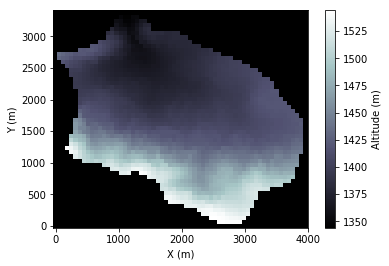

In [8]:
# Boundary conditions 
# The dem has values of -99999 outside the watershed area with only lowest point set as open
noDataValue = -99999
rmg.set_watershed_boundary_condition(z, nodata_value=noDataValue)

imshow_grid(rmg, 'topographic__elevation', 
            cmap='bone',
#             plot_name='Watershed topography',
            grid_units=['m','m'],var_name='Altitude',var_units='m')
# plt.savefig('topography.eps')
plt.savefig('topography.png', dpi=300)


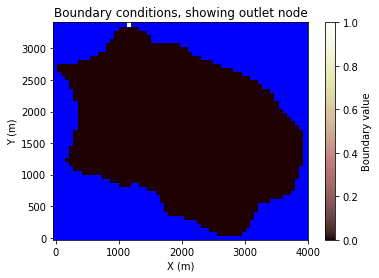

In [9]:
# Visualise the boundary conditions and the outlet point
imshow_grid(rmg, rmg.status_at_node,color_for_closed='blue',plot_name='Boundary conditions, showing outlet node',
            grid_units=['m','m'],var_name='Boundary value')

The outlet node is at 3242
The links at the outlet node are: [6414   -1 6413 6352]
The status at the links are: [4 4 4 0]
The flux directions at the links are: [0 0 0 1]
Outlet link to monitor is set to 6352


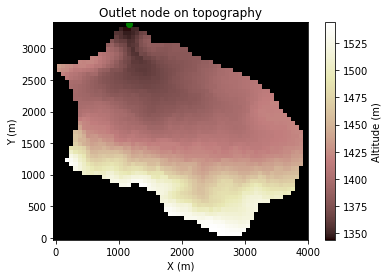

In [10]:
# Set the outlet node value
outlet_node = np.where(rmg.status_at_node==1)
print('The outlet node is at {}'.format(outlet_node[0][0]))

# Get information about the links at the outlet node
linksAtNode = rmg.links_at_node[outlet_node][0]
print('The links at the outlet node are: {}'.format(linksAtNode))

# Status of links at the outlet node:
# 0: active
# 2: fixed
# 4: inactive
linkStatus = rmg.status_at_link[rmg.links_at_node[outlet_node]][0]
print('The status at the links are: {}'.format(linkStatus))

# Link flux directions at each node: 
#  1: incoming flux
# -1: outgoing flux
#  0: no flux 
fluxAtLink = rmg.active_link_dirs_at_node[outlet_node][0]
print('The flux directions at the links are: {}'.format(fluxAtLink))

# set the link to the avtive one
outlet_link = linksAtNode[np.where(linkStatus == 0)[0] and np.where(fluxAtLink != 0)[0]][0]
print('Outlet link to monitor is set to {}'.format(outlet_link))

# Visualise the outlet node
imshow_grid(rmg, z, plot_name='Outlet node on topography',
            grid_units=['m','m'],var_name='Altitude',var_units='m')
plt.plot(rmg.node_x[outlet_node],rmg.node_y[outlet_node],'go')
plt.show()

### Set up the components

In [11]:
# Set up the OverlandFlow component
of = OverlandFlow(rmg, mannings_n = mannings_n, steep_slopes = True)

# Set up the SoilInfiltrationGreenAmpt component
SI = SoilInfiltrationGreenAmpt(rmg, soil_type = soil_type, hydraulic_conductivity=hydraulic_conductivity)

## Run simulation

In [12]:
# Simulation loop
elapsed_time = 0.
next_report = 0.  
fig = 1

# Lists for saving data
discharge_at_outlet = []
hydrograph_time = []

# Simulation Loop
while elapsed_time < model_run_time:
    
    # Setting the adaptive time step
    of.dt = of.calc_time_step()

    # The storm starts when the model starts
    # While the elapsed time is less than the storm duration, add water to the system as rainfall
    if elapsed_time < (storm_duration):
        of.rainfall_intensity =  starting_precip_ms   
        
    # elapsed time exceeds the storm duration, rainfall ceases
    else: 
        of.rainfall_intensity = 0.0

    # Generating overland flow component
    of.overland_flow() 

    # Append time and discharge to lists to save data for plotting
    hydrograph_time.append(elapsed_time/3600.)                     # hours
    discharge_at_outlet.append(np.abs(of.q[outlet_link]) * rmg.dx) # m^3/s

    # Run soil infiltration component
    SI.run_one_step(of.dt)
    
    # Report if requested
    if elapsed_time >= next_report:
        if showPlots:
            plt.figure(fig)
            fig = fig + 1
            imshow_grid(rmg, 'soil_water_infiltration__depth', cmap='Blues',
                        grid_units=['m','m'],var_name='Soil water infiltration depth',var_units='m')
            plt.title('Elapsed time {:.2f} hours'.format(elapsed_time/3600.))
            
        elif showProgress:
            print('elapsed time = {:.2f} s [{:.2f} hours]'.format(elapsed_time,elapsed_time/3600.))
 
        next_report += reportInterval

    # Update elapsed_time
    elapsed_time += of.dt

elapsed time = 0.00 s [0.00 hours]
elapsed time = 6006.22 s [1.67 hours]
elapsed time = 12006.28 s [3.34 hours]


## Simulation output

Maximum discharge at the outlet node = 24.085 m3/s


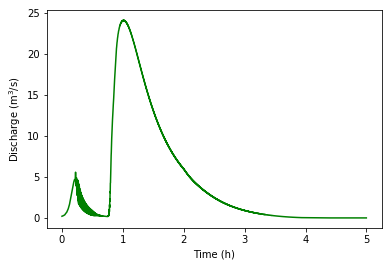

In [13]:
# Hydrograph at the outlet node
plt.plot(hydrograph_time, discharge_at_outlet, 'g')
plt.xlabel('Time (h)')
plt.ylabel('Discharge (m$^3$/s)')
# plt.title('Outlet node hydrograph, {} mm/hr for duration of {} hr'.format(starting_precip_mmhr, storm_duration/3600.))
plt.savefig('hydrograph.png', dpi=300)

print('Maximum discharge at the outlet node = {:.3f} m3/s'.format(max(discharge_at_outlet)))

Cumulative discharge at the outlet node = 79452.025 m3


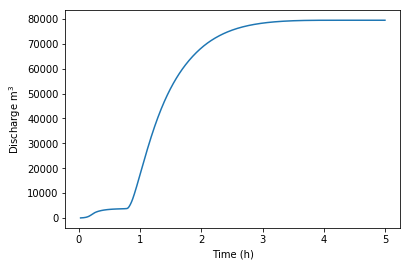

In [14]:
# Cumulative water flow at outlet node
tot_volume_mid = np.cumsum(np.array(discharge_at_outlet)[1:]*np.diff(np.array(hydrograph_time)))*3600.

plt.plot(hydrograph_time[1:], tot_volume_mid)
# plt.title('Cumulative water flow')
plt.ylabel('Discharge m$^3$')
plt.xlabel('Time (h)')
print('Cumulative discharge at the outlet node = {:.3f} m3'.format(sum(np.abs(discharge_at_outlet)[1:]*np.diff(np.array(hydrograph_time))*3600.)))
plt.savefig('cumWaterFlow.png', dpi=300)
